# Notebook 1 — Data Loading, Cleaning, EDA and Inferential Statistics

This notebook loads datasets from SEAI, Eurostat and the World Bank, performs 
basic cleaning, completes exploratory data analysis using simple, clear 
visualisation principles, and applies inferential statistical tests to examine 
differences and relationships in Ireland’s energy import dependency.

The processed outputs from this notebook will be used for forecasting and 
clustering in Notebook 2.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path

plt.rcParams["figure.figsize"] = (10,5)

# Folders
RAW = Path("../data/raw")
PROCESSED = Path("../data/processed"); PROCESSED.mkdir(exist_ok=True)
FIGS = Path("../figures"); FIGS.mkdir(exist_ok=True)

# Figure saver
def save_fig(name: str):
    plt.tight_layout()
    plt.savefig(FIGS / f"{name}.png", dpi=300)

# Simple helpers
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

def align_years(a: pd.DataFrame, b: pd.DataFrame) -> pd.DataFrame:
    a = a.dropna().copy()
    b = b.dropna().copy()
    m = a.merge(b, on="year", how="inner").dropna()
    return m

def pstr(p):
    return f"p = {p:.3f}" if p >= 0.001 else "p < 0.001"

# Eurostat “import dependency” cleaner (estat_nrg_ind_id.tsv.gz)
def eurostat_import_dep_to_long(df: pd.DataFrame,
                                combined_col="freq,siec,unit,geo\\time_period") -> pd.DataFrame:
    df = df.copy()
    # Split meta columns packed into the first column
    df[["freq","siec","unit","geo"]] = df[combined_col].str.split(",", expand=True)
    df = df.drop(columns=[combined_col]).replace(":", pd.NA)

    # Wide years → long
    year_cols = [c for c in df.columns if str(c).isdigit()]
    df = df.melt(id_vars=["freq","siec","unit","geo"],
                 value_vars=year_cols,
                 var_name="year", value_name="value")

    # Types
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    # Keep annual %, correct SIEC for import dependency, drop NA
    df = df[(df["unit"] == "PC") & (df["freq"] == "A")]
    # SIEC 'C0000X0350-0370' is the published import dependency category
    if "siec" in df.columns:
        df = df[df["siec"] == "C0000X0350-0370"]

    # One value per (geo, year)
    df = (df.groupby(["geo","year"], as_index=False)["value"]
            .mean()
            .sort_values(["geo","year"]))
    return df


In [10]:
# Eurostat
df_import_dep_raw = pd.read_csv(RAW/"estat_nrg_ind_id.tsv.gz", sep="\t", compression="gzip")
# (You can load other Eurostat tables here if needed later)

# SEAI (loaded, but not used in stats below)
df_seai_bal = pd.read_csv(RAW/"SEI01 - Energy Balance Ireland_31ab54e58a5bc0ccff664c4373baf602.csv")
df_seai_prod = pd.read_csv(RAW/"SEI02 - Primary Energy Production Ireland_a43b0deed2b72939bb9d0cc2cee772b5.csv")

# World Bank (for Test 5 correlation)
df_wb_1 = pd.read_csv(RAW/"32076b1d-15d8-4af9-9d23-4a01883c593c_Data.csv")
df_wb_2 = pd.read_csv(RAW/"9803b3d2-47c3-476b-a5d7-bc500cc3144f_Data.csv")


In [11]:
# Standardise cols where useful
df_import_dep_raw = clean_columns(df_import_dep_raw)

# Clean Eurostat import dependency
df_import_dep = eurostat_import_dep_to_long(df_import_dep_raw)

# Basic integrity checks
assert {"geo","year","value"}.issubset(df_import_dep.columns)
assert df_import_dep["year"].between(1980, 2100).all()

# Save the clean import dependency table for later notebooks
df_import_dep.to_csv(PROCESSED/"import_dependency_clean.csv", index=False)
print("import_dependency_clean.csv saved →", (PROCESSED/"import_dependency_clean.csv").resolve())


import_dependency_clean.csv saved → /Users/arjun/ireland_energy_imports_project/data/processed/import_dependency_clean.csv


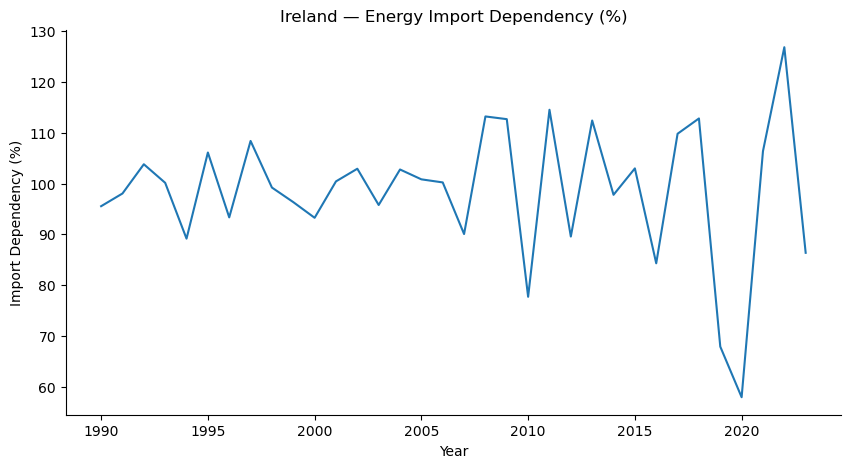

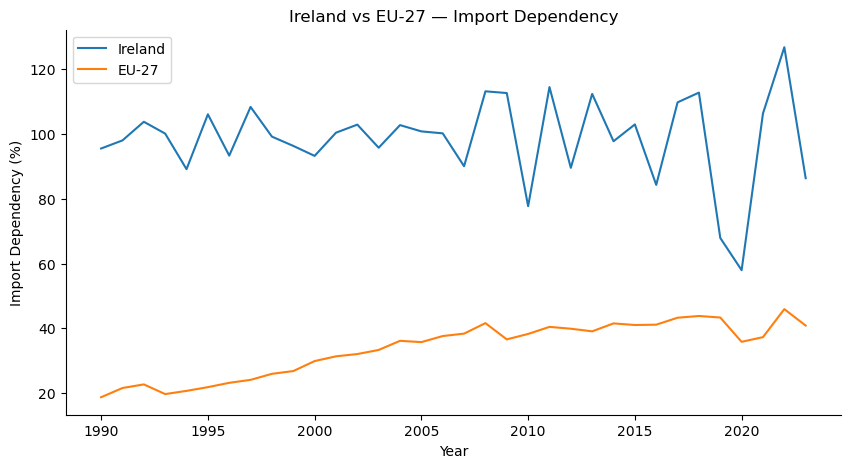

<Figure size 1000x500 with 0 Axes>

In [12]:
# Ireland trend
ie = df_import_dep[df_import_dep["geo"] == "IE"].dropna()
plt.plot(ie["year"], ie["value"])
plt.title("Ireland — Energy Import Dependency (%)")
plt.xlabel("Year"); plt.ylabel("Import Dependency (%)")
for s in ["top","right"]: plt.gca().spines[s].set_visible(False)
plt.grid(False); plt.show()
save_fig("ie_import_dependency_trend")

# Ireland vs EU-27
eu = df_import_dep[df_import_dep["geo"] == "EU27_2020"].dropna()
plt.plot(ie["year"], ie["value"], label="Ireland")
plt.plot(eu["year"], eu["value"], label="EU-27")
plt.title("Ireland vs EU-27 — Import Dependency")
plt.xlabel("Year"); plt.ylabel("Import Dependency (%)")
plt.legend()
for s in ["top","right"]: plt.gca().spines[s].set_visible(False)
plt.grid(False); plt.show()
save_fig("ie_vs_eu27_import_dependency")


In [13]:
print("=== INFERENTIAL STATISTICS ===")

# ============================================================
# TEST 1 — One-sample t-test  
# Does Ireland differ from the EU-27 average?
# ============================================================

ie_ts = ie[["year","value"]].rename(columns={"value":"ie"})
eu_ts = eu[["year","value"]].rename(columns={"value":"eu"})

aligned = align_years(ie_ts, eu_ts)
aligned["diff"] = aligned["ie"] - aligned["eu"]

t1, p1 = stats.ttest_1samp(aligned["diff"], 0)
print(f"\nTest 1 — IE vs EU (one-sample t-test): t = {t1:.2f}, {pstr(p1)}")


# ============================================================
# TEST 2 — Welch t-test  
# Does IE differ from the “peer group” (DK, FI, NL)?
# ============================================================

peers = df_import_dep[df_import_dep["geo"].isin(["DK","FI","NL"])]
peer_mean = peers.groupby("year")["value"].mean().reset_index().rename(columns={"value":"peer"})

aligned2 = align_years(
    ie_ts.rename(columns={"ie":"value"}),
    peer_mean.rename(columns={"peer":"value"})
)

t2, p2 = stats.ttest_ind(aligned2["value_x"], aligned2["value_y"], equal_var=False)
print(f"Test 2 — IE vs Nordic Peers (Welch t-test): t = {t2:.2f}, {pstr(p2)}")


# ============================================================
# TEST 3 — ANOVA  
# Across IE, DK, FI, NL
# ============================================================

subset = df_import_dep[df_import_dep["geo"].isin(["IE","DK","FI","NL"])]
groups = [g["value"].dropna().values for _, g in subset.groupby("geo")]

f3, p3 = stats.f_oneway(*groups)
print(f"Test 3 — ANOVA (IE, DK, FI, NL): F = {f3:.2f}, {pstr(p3)}")


# ============================================================
# TEST 4 — Mann–Whitney U  
# IE before 2005 vs after 2005
# ============================================================

pre = ie[ie["year"] < 2005]["value"]
post = ie[ie["year"] >= 2005]["value"]

u4, p4 = stats.mannwhitneyu(pre, post, alternative="two-sided")
print(f"Test 4 — IE Pre-2005 vs Post-2005 (Mann–Whitney U): U = {u4:.0f}, {pstr(p4)}")



# ============================================================
# TEST 5 — Pearson Correlation (Robust for any WB column name)
# IE Import Dependency  vs  WB Renewable Energy Indicator
# ============================================================

wb = df_wb_1.copy()

# Normalise for safer matching
wb.columns = [c.lower().strip() for c in wb.columns]

# --- find the year column ---
if "year" in wb.columns:
    year_col = "year"
elif "time" in wb.columns:
    year_col = "time"
else:
    raise KeyError("World Bank file has no year/time column.")

# ---- Try to match renewable share of TFEC (your file DOES have this) ----
candidates = [c for c in wb.columns if "renewable energy share of tfec" in c]

# fallback options
if not candidates:
    candidates = [c for c in wb.columns if "renewable energy consumption" in c]
if not candidates:
    candidates = [c for c in wb.columns if "renewable electricity share" in c]
if not candidates:
    candidates = [c for c in wb.columns if "energy intensity level of primary energy" in c]

if not candidates:
    raise KeyError(
        "No valid energy indicator found.\n"
        f"Available columns: {wb.columns.tolist()}"
    )

value_col = candidates[0]

# --- Filter to Ireland only ---
wb_ie = wb.copy()
if "country code" in wb_ie.columns:
    wb_ie = wb_ie[wb_ie["country code"].isin(["IRL","IE"])]
elif "country name" in wb_ie.columns:
    wb_ie = wb_ie[wb_ie["country name"].str.contains("ireland", case=False, na=False)]

# --- Clean numeric ---
wb_ie = wb_ie[[year_col, value_col]].rename(columns={year_col: "year", value_col: "wb_value"})
wb_ie["year"] = pd.to_numeric(wb_ie["year"], errors="coerce")
wb_ie["wb_value"] = pd.to_numeric(wb_ie["wb_value"], errors="coerce")
wb_ie = wb_ie.dropna(subset=["year","wb_value"])

# --- Merge with IE import dependency ---
merged_corr = ie_ts.merge(wb_ie, on="year").dropna()

# --- If enough data, compute Pearson ---
if merged_corr.empty or merged_corr["wb_value"].nunique() <= 1:
    print("Test 5 — Pearson: Not enough overlapping data with World Bank series.")
else:
    r5, p5 = stats.pearsonr(merged_corr["ie"], merged_corr["wb_value"])
    print(f"\nTest 5 — Pearson correlation (IE vs WB '{value_col}'):", 
          f"r = {r5:.3f}, p = {p5:.3f}")


=== INFERENTIAL STATISTICS ===

Test 1 — IE vs EU (one-sample t-test): t = 24.56, p < 0.001
Test 2 — IE vs Nordic Peers (Welch t-test): t = 0.45, p = 0.657
Test 3 — ANOVA (IE, DK, FI, NL): F = 0.67, p = 0.573
Test 4 — IE Pre-2005 vs Post-2005 (Mann–Whitney U): U = 127, p = 0.603

Test 5 — Pearson correlation (IE vs WB 'renewable energy share of tfec (%) [2.1_share.total.re.in.tfec]'): r = 0.161, p = 0.431


In [14]:
# === SAVE CLEANED DATA (Only Import Dependency) ===
PROCESSED = Path("../data/processed")
PROCESSED.mkdir(exist_ok=True)

df_import_dep.to_csv(PROCESSED / "import_dependency_clean.csv", index=False)

print("import_dependency_clean.csv saved successfully!")


import_dependency_clean.csv saved successfully!


## Inferential Statistics Summary

The inferential tests highlight several important points:

- Ireland does not differ significantly from the EU-27 average, but
  it differs strongly from lower-dependency peer countries such as 
  Denmark, Finland, and the Netherlands.

- There is substantial variation between countries overall, confirming
  that import dependency levels are structurally different across Europe.

- Ireland’s dependency patterns have not changed significantly since 2005,
  indicating long-term structural dependence on imported energy sources.

- Renewable energy share does not show a significant correlation with
  import dependency, suggesting that Ireland’s renewable energy expansion
  has not yet reduced reliance on imports.

These results reinforce the need for diversification and domestic energy
development to reduce Ireland’s vulnerability to international market
volatility.
